## Import Libraries

In [1]:
# Importing all the necessary packages for model development and deployment
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import joblib
import streamlit as st
from PIL import Image, ImageOps

In [2]:
# Creating function for displaying confusion matrix
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()


## Loading MNIST datasets from Scikit Learn

In [3]:
# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1, parser='auto', cache=True, as_frame=False)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

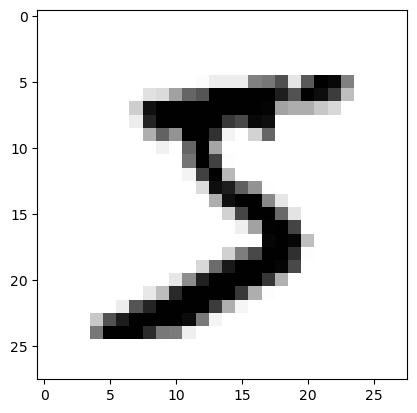

In [4]:
# Visualizing MNIST data by taking only one record.
# Plotting the features of the X data, it looks like a 5.
some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary)
# plt.axis("off")

In [5]:
# The first label ("true answer") is 5. 
y[0]

5

## Splitting Datasets

In [6]:
# Split the data into training, validation and testing sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=10000, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=10000, random_state=42)

In [7]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 784)
(50000,)
(10000, 784)
(10000,)
(10000, 784)
(10000,)


## Applying Standardization and Dimentionality Reduction

In [8]:
# Standardizing the data.
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)  # Only transforming the validation data. 
X_test_scaled = scaler.transform(X_test)  # Only transforming the test data.

In [9]:
# Apply PCA
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca = pca.fit_transform(X_train_scaled)
X_val_pca = pca.transform(X_val_scaled)
X_test_pca = pca.transform(X_test_scaled)

# We are going to use the above processed datasets only in Logistic regression and KNN model for the effective performance.
# But Decision Tree and Random forest does not need scaling and PCA technique because it may affect the model performance.

## Parameter Grid

In [10]:
# Define parameter grids for hyperparameter tuning
param_grid_lr = {
    'classifier__C': [0.01, 0.1, 1]
}

param_grid_dt = {
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4]
}

param_grid_rf = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 5, 10],
    'classifier__min_samples_split': [2, 5, 7]
}

param_grid_knn = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance']
}

## Pipeline Creation

In [11]:
# Build pipelines for each model
pipe_lr = Pipeline([
    ('classifier', LogisticRegression(max_iter=2000)) # when training, model requires to increase "max_iter" parameter.
])

pipe_dt = Pipeline([
    ('classifier', DecisionTreeClassifier())
])

pipe_rf = Pipeline([
    ('classifier', RandomForestClassifier())
])

pipe_knn = Pipeline([
    ('classifier', KNeighborsClassifier())
])

## Applying GridsearchCV and Fitting the model

In [12]:
# Create GridSearchCV instances for each model
grid_search_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=5, scoring='accuracy')
grid_search_dt = GridSearchCV(pipe_dt, param_grid_dt, cv=5, scoring='accuracy')
grid_search_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=5, scoring='accuracy')
grid_search_knn = GridSearchCV(pipe_knn, param_grid_knn, cv=5, scoring='accuracy')

In [13]:
# Fit GridSearchCV to training data
grid_search_lr.fit(X_train_pca, y_train)
grid_search_dt.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_knn.fit(X_train_pca, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', KNeighborsClassifier())]),
             param_grid={'classifier__n_neighbors': [3, 5, 7],
                         'classifier__weights': ['uniform', 'distance']},
             scoring='accuracy')

In [14]:
# save the trained model

joblib.dump(grid_search_lr, "model_lr.pkl") 
joblib.dump(grid_search_dt, "model_dt.pkl") 
joblib.dump(grid_search_rf, "model_rf.pkl") 
joblib.dump(grid_search_knn, "model_knn.pkl") 

# load
#clf2 = joblib.load("model.pkl")

['model_knn.pkl']

In [15]:
# Calculating the best parameter for every model
best_lr = grid_search_lr.best_params_
best_dt = grid_search_dt.best_params_
best_rf = grid_search_rf.best_params_
best_knn = grid_search_knn.best_params_

In [16]:
# Print best parameter
print("Best Parameter - Logistic Regression:",best_lr)
print("Best Parameter  - Decision Tree:", best_dt)
print("Best Parameter  - Random Forest:", best_rf)
print("Best Parameter  - KNN:", best_knn )

Best Parameter - Logistic Regression: {'classifier__C': 0.1}
Best Parameter  - Decision Tree: {'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}
Best Parameter  - Random Forest: {'classifier__max_depth': None, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}
Best Parameter  - KNN: {'classifier__n_neighbors': 3, 'classifier__weights': 'distance'}


## Prediction and Evaluation

In [17]:
# Prediction on X validation set
y_pred_gs_lr = grid_search_lr.predict(X_val_pca)
y_pred_gs_dt = grid_search_dt.predict(X_val)
y_pred_gs_rf = grid_search_rf.predict(X_val)
y_pred_gs_knn = grid_search_knn.predict(X_val_pca)

In [18]:
# Evaluate models on validation set
val_accuracy_lr = accuracy_score(y_val, y_pred_gs_lr)
val_accuracy_dt = accuracy_score(y_val, y_pred_gs_dt)
val_accuracy_rf = accuracy_score(y_val, y_pred_gs_rf)
val_accuracy_knn = accuracy_score(y_val, y_pred_gs_knn)

In [19]:
# Print validation accuracies
print("Validation Accuracy - Logistic Regression:", val_accuracy_lr)
print("Validation Accuracy - Decision Tree:", val_accuracy_dt)
print("Validation Accuracy - Random Forest:", val_accuracy_rf)
print("Validation Accuracy - KNN:", val_accuracy_knn)



Validation Accuracy - Logistic Regression: 0.9212
Validation Accuracy - Decision Tree: 0.871
Validation Accuracy - Random Forest: 0.972
Validation Accuracy - KNN: 0.9517


## From the validation accuracies, we can say that Random Forest Classifier performs better than other models.

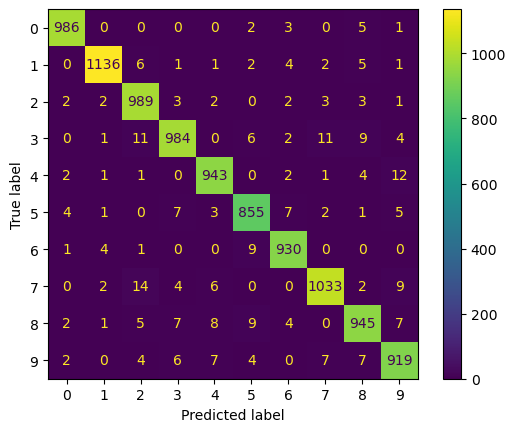

In [20]:
# Since we have got best model as random forest, so we display the confusion matrix for it.
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
display_confusion_matrix(y_val, y_pred_gs_rf)

In [21]:
# Evaluate the best model on the test set
y_pred_test = grid_search_rf.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print("Test Accuracy - Random Forest (Selected Model):", test_accuracy)

Test Accuracy - Random Forest (Selected Model): 0.9649


## Model Deployment

In [22]:
# From here we are preparing for the selected random forest model for deployment in Streamlit Application

# Main Streamlit app
def main():
    st.title('Welcome to the portal - Recognition of Handwritten digits')
    st.markdown('## Here you can upload your image')   
    st.write('The purpose of this portal is to check whether the random forest model predicts the handwritten digits image correctly or not')      

    # Upload image
    uploaded_image = st.file_uploader("Upload Image", type=["jpg", "jpeg", "png"])

    if uploaded_image is not None:

        # Display uploaded image
        st.image(uploaded_image, caption='Uploaded Image', use_column_width=True)

        # Open the image file
        image = Image.open(uploaded_image)
        
        # Preprocess the image
        grayscale_image = image.convert('L')  # Convert to grayscale
        inverted_image = ImageOps.invert(grayscale_image) # Inverting the color of digit and background
        resized_image = inverted_image.resize((28, 28))  # Resize image to 28x28 because our input data in model development is 28x28 as well.
            
        # Convert image to 784 features
        data = np.asarray(resized_image)  # Convert image to numpy array
        features = data.flatten()  # Flatten the array to 1D
        #features = features.reshape(1, -1)  # Reshape to match model input shape

        # Display prediction
        st.subheader("Prediction Interface")
        prediction = grid_search_rf.predict([features])[0]
        
        # Display preprocessed image
        st.subheader("Preprocessed Image")
        st.image(resized_image, caption='Preprocessed Image (Grayscale, 28x28)', use_column_width=True)
        
        # Display prediction
        st.markdown(f"## Predicted digit: {prediction}")

if __name__ == '__main__':
    main()

2024-03-19 12:40:12.611 
  command:

    streamlit run C:\Users\dines\anaconda3\envs\pystat\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


## Thank you